In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from pathlib import Path
import re
import seaborn as sns

In [2]:
ROOT = Path.cwd().resolve()

DATA = (ROOT / "data").resolve()

PROV_SVC_DATA = (DATA / "prov_svc").resolve()

PROV_DATA = (DATA / "prov").resolve()

# Provider Service Data

In [3]:
prov_svc_2021 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D21_Prov_Svc.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/3370792790.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_svc_2021 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D21_Prov_Svc.csv")


In [4]:
prov_svc_2021["Year"] = 2021

In [5]:
prov_svc_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9886177 entries, 0 to 9886176
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Rndrng_NPI                     int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Ent_Cd            object 
 6   Rndrng_Prvdr_St1               object 
 7   Rndrng_Prvdr_St2               object 
 8   Rndrng_Prvdr_City              object 
 9   Rndrng_Prvdr_State_Abrvtn      object 
 10  Rndrng_Prvdr_State_FIPS        object 
 11  Rndrng_Prvdr_Zip5              object 
 12  Rndrng_Prvdr_RUCA              float64
 13  Rndrng_Prvdr_RUCA_Desc         object 
 14  Rndrng_Prvdr_Cntry             object 
 15  Rndrng_Prvdr_Type              object 
 16  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  object 
 17  HCPCS_Cd                       object 
 18  HC

In [6]:
prov_svc_2022 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D22_Prov_Svc.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/768223468.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_svc_2022 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D22_Prov_Svc.csv")


In [7]:
prov_svc_2022["Year"] = 2022

In [8]:
prov_svc_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9755427 entries, 0 to 9755426
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Rndrng_NPI                     int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Ent_Cd            object 
 6   Rndrng_Prvdr_St1               object 
 7   Rndrng_Prvdr_St2               object 
 8   Rndrng_Prvdr_City              object 
 9   Rndrng_Prvdr_State_Abrvtn      object 
 10  Rndrng_Prvdr_State_FIPS        object 
 11  Rndrng_Prvdr_Zip5              object 
 12  Rndrng_Prvdr_RUCA              float64
 13  Rndrng_Prvdr_RUCA_Desc         object 
 14  Rndrng_Prvdr_Cntry             object 
 15  Rndrng_Prvdr_Type              object 
 16  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  object 
 17  HCPCS_Cd                       object 
 18  HC

In [9]:
prov_svc_2023 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/3955429083.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_svc_2023 = pd.read_csv(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv")


In [10]:
prov_svc_2023["Year"] = 2023

In [11]:
prov_svc_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9660647 entries, 0 to 9660646
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Rndrng_NPI                     int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Ent_Cd            object 
 6   Rndrng_Prvdr_St1               object 
 7   Rndrng_Prvdr_St2               object 
 8   Rndrng_Prvdr_City              object 
 9   Rndrng_Prvdr_State_Abrvtn      object 
 10  Rndrng_Prvdr_State_FIPS        object 
 11  Rndrng_Prvdr_Zip5              object 
 12  Rndrng_Prvdr_RUCA              float64
 13  Rndrng_Prvdr_RUCA_Desc         object 
 14  Rndrng_Prvdr_Cntry             object 
 15  Rndrng_Prvdr_Type              object 
 16  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  object 
 17  HCPCS_Cd                       object 
 18  HC

In [12]:
prov_svc_all = pd.concat([prov_svc_2021, prov_svc_2022, prov_svc_2023], axis= 0).reset_index(drop=True)

In [13]:
prov_svc_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29302251 entries, 0 to 29302250
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Rndrng_NPI                     int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Ent_Cd            object 
 6   Rndrng_Prvdr_St1               object 
 7   Rndrng_Prvdr_St2               object 
 8   Rndrng_Prvdr_City              object 
 9   Rndrng_Prvdr_State_Abrvtn      object 
 10  Rndrng_Prvdr_State_FIPS        object 
 11  Rndrng_Prvdr_Zip5              object 
 12  Rndrng_Prvdr_RUCA              float64
 13  Rndrng_Prvdr_RUCA_Desc         object 
 14  Rndrng_Prvdr_Cntry             object 
 15  Rndrng_Prvdr_Type              object 
 16  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  object 
 17  HCPCS_Cd                       object 
 18  

# Provider Data

In [14]:
prov_2021 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D21_Prov.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/2226923251.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_2021 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D21_Prov.csv")


In [15]:
prov_2021["Year"] = 2021

In [16]:
prov_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198754 entries, 0 to 1198753
Data columns (total 82 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Rndrng_NPI                        1198754 non-null  int64  
 1   Rndrng_Prvdr_Last_Org_Name        1198754 non-null  object 
 2   Rndrng_Prvdr_First_Name           1133917 non-null  object 
 3   Rndrng_Prvdr_MI                   766815 non-null   object 
 4   Rndrng_Prvdr_Crdntls              1051513 non-null  object 
 5   Rndrng_Prvdr_Ent_Cd               1198754 non-null  object 
 6   Rndrng_Prvdr_St1                  1198754 non-null  object 
 7   Rndrng_Prvdr_St2                  300760 non-null   object 
 8   Rndrng_Prvdr_City                 1198754 non-null  object 
 9   Rndrng_Prvdr_State_Abrvtn         1198754 non-null  object 
 10  Rndrng_Prvdr_State_FIPS           1198754 non-null  object 
 11  Rndrng_Prvdr_Zip5                 119

In [17]:
prov_2022 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D22_Prov.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/534870313.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_2022 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P07_V20_D22_Prov.csv")


In [18]:
prov_2022["Year"] = 2022

In [19]:
prov_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230293 entries, 0 to 1230292
Data columns (total 82 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Rndrng_NPI                        1230293 non-null  int64  
 1   Rndrng_Prvdr_Last_Org_Name        1230293 non-null  object 
 2   Rndrng_Prvdr_First_Name           1165648 non-null  object 
 3   Rndrng_Prvdr_MI                   780696 non-null   object 
 4   Rndrng_Prvdr_Crdntls              1073919 non-null  object 
 5   Rndrng_Prvdr_Ent_Cd               1230293 non-null  object 
 6   Rndrng_Prvdr_St1                  1230292 non-null  object 
 7   Rndrng_Prvdr_St2                  280330 non-null   object 
 8   Rndrng_Prvdr_City                 1230293 non-null  object 
 9   Rndrng_Prvdr_State_Abrvtn         1230293 non-null  object 
 10  Rndrng_Prvdr_State_FIPS           1230292 non-null  object 
 11  Rndrng_Prvdr_Zip5                 123

In [20]:
prov_2023 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P05_V20_D23_Prov.csv")

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/4145342260.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  prov_2023 = pd.read_csv(PROV_DATA / "MUP_PHY_R25_P05_V20_D23_Prov.csv")


In [21]:
prov_2023["Year"] = 2023

In [22]:
prov_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259343 entries, 0 to 1259342
Data columns (total 82 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Rndrng_NPI                        1259343 non-null  int64  
 1   Rndrng_Prvdr_Last_Org_Name        1259343 non-null  object 
 2   Rndrng_Prvdr_First_Name           1196534 non-null  object 
 3   Rndrng_Prvdr_MI                   793381 non-null   object 
 4   Rndrng_Prvdr_Crdntls              1095675 non-null  object 
 5   Rndrng_Prvdr_Ent_Cd               1259343 non-null  object 
 6   Rndrng_Prvdr_St1                  1259343 non-null  object 
 7   Rndrng_Prvdr_St2                  260684 non-null   object 
 8   Rndrng_Prvdr_City                 1259343 non-null  object 
 9   Rndrng_Prvdr_State_Abrvtn         1259343 non-null  object 
 10  Rndrng_Prvdr_State_FIPS           1259342 non-null  object 
 11  Rndrng_Prvdr_Zip5                 125

In [23]:
prov_all = pd.concat([prov_2021, prov_2022, prov_2023], axis=0).reset_index(drop=True)

In [24]:
prov_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3688390 entries, 0 to 3688389
Data columns (total 82 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Rndrng_NPI                        int64  
 1   Rndrng_Prvdr_Last_Org_Name        object 
 2   Rndrng_Prvdr_First_Name           object 
 3   Rndrng_Prvdr_MI                   object 
 4   Rndrng_Prvdr_Crdntls              object 
 5   Rndrng_Prvdr_Ent_Cd               object 
 6   Rndrng_Prvdr_St1                  object 
 7   Rndrng_Prvdr_St2                  object 
 8   Rndrng_Prvdr_City                 object 
 9   Rndrng_Prvdr_State_Abrvtn         object 
 10  Rndrng_Prvdr_State_FIPS           object 
 11  Rndrng_Prvdr_Zip5                 object 
 12  Rndrng_Prvdr_RUCA                 float64
 13  Rndrng_Prvdr_RUCA_Desc            object 
 14  Rndrng_Prvdr_Cntry                object 
 15  Rndrng_Prvdr_Type                 object 
 16  Rndrng_Prvdr_Mdcr_Prtcptg_Ind     ob

In [25]:
prov_svc_all.head(10)

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,...,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Year
0,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,O,116,191.0,191,125.000000,107.532880,83.908220,70.375864,2021
1,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,O,40,47.0,47,173.829787,152.075957,118.570638,99.791489,2021
2,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,38,39.0,39,257.620513,75.891282,61.066923,56.983077,2021
3,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,21,21.0,21,1192.656191,187.146190,141.442857,134.378571,2021
4,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,12,12.0,12,319.666667,143.029167,105.700833,97.825000,2021
5,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,18,18.0,18,1093.820556,207.283333,170.388889,161.382222,2021
6,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,16,16.0,16,409.875000,111.575000,84.338125,75.948750,2021
7,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,17,29.0,29,84.758621,38.948621,31.255862,30.090690,2021
8,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,124,204.0,204,164.450980,73.325882,58.462108,56.195049,2021
9,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,...,N,F,206,336.0,336,286.854167,106.597173,84.875327,80.373720,2021


In [26]:
prov_svc_all["Rndrng_Prvdr_Ent_Cd"].value_counts()

Rndrng_Prvdr_Ent_Cd
I    27622072
O     1680179
Name: count, dtype: int64

In [27]:
onco_prvdr_type = [s for s in prov_svc_all["Rndrng_Prvdr_Type"].value_counts().index.to_list() if "onco" in s.lower()]
onco_prvdr_type

['Hematology-Oncology',
 'Radiation Oncology',
 'Medical Oncology',
 'Gynecological Oncology',
 'Surgical Oncology']

In [28]:
counts_df = prov_svc_all["Rndrng_Prvdr_Type"].value_counts().reset_index().rename(columns={"count": "Count"})

onco_counts = counts_df[counts_df["Rndrng_Prvdr_Type"].isin(onco_prvdr_type)]

onco_counts

,Rndrng_Prvdr_Type,Count
17,Hematology-Oncology,463136
30,Radiation Oncology,237530
39,Medical Oncology,155537
68,Gynecological Oncology,22439
70,Surgical Oncology,20382


In [29]:
prov_svc_all_cdI_typeOnco = prov_svc_all[(prov_svc_all["Rndrng_Prvdr_Ent_Cd"]=="I") & prov_svc_all["Rndrng_Prvdr_Type"].isin(onco_prvdr_type)].reset_index()

In [30]:
prov_svc_all_cdI_typeOnco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899024 entries, 0 to 899023
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index                          899024 non-null  int64  
 1   Rndrng_NPI                     899024 non-null  int64  
 2   Rndrng_Prvdr_Last_Org_Name     899024 non-null  object 
 3   Rndrng_Prvdr_First_Name        899024 non-null  object 
 4   Rndrng_Prvdr_MI                610588 non-null  object 
 5   Rndrng_Prvdr_Crdntls           872590 non-null  object 
 6   Rndrng_Prvdr_Ent_Cd            899024 non-null  object 
 7   Rndrng_Prvdr_St1               899024 non-null  object 
 8   Rndrng_Prvdr_St2               268687 non-null  object 
 9   Rndrng_Prvdr_City              899024 non-null  object 
 10  Rndrng_Prvdr_State_Abrvtn      899024 non-null  object 
 11  Rndrng_Prvdr_State_FIPS        899024 non-null  object 
 12  Rndrng_Prvdr_Zip5             

In [31]:
prov_svc_all_cdI_typeOnco["Rndrng_Prvdr_Type"].value_counts()

Rndrng_Prvdr_Type
Hematology-Oncology       463136
Radiation Oncology        237530
Medical Oncology          155537
Gynecological Oncology     22439
Surgical Oncology          20382
Name: count, dtype: int64

# SWITCH TO DUCKDB FOR EFFICIENCY (USE THE FOR THE REST OF THE NOTEBOOK)

In [32]:
con = duckdb.connect(database=DATA / "medicare.duckdb")

# ----------------------------
# Step 1: Provider-service union (3 years)
# ----------------------------

con.execute(
    f"""
CREATE OR REPLACE VIEW prov_svc_all AS
SELECT *, 2021 AS Year
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D21_Prov_Svc.csv").as_posix()}')
UNION ALL
SELECT *, 2022 AS Year 
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D22_Prov_Svc.csv").as_posix()}')
UNION ALL
SELECT *, 2023 As Year
FROM read_csv_auto('{(PROV_SVC_DATA / "MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv").as_posix()}');
"""
)

In [33]:
# Oncology provider types: contains "onco"

con.execute("""
CREATE OR REPLACE VIEW prov_svc_onco AS
SELECT *
FROM prov_svc_all
WHERE Rndrng_Prvdr_Ent_Cd = 'I'
  AND Rndrng_Prvdr_Type IN (
    'Hematology-Oncology',
    'Medical Oncology',
    'Radiation Oncology',
    'Gynecological Oncology',
    'Surgical Oncology'
  );
""")



In [34]:
con.execute("""
CREATE OR REPLACE VIEW prov_svc_onco_core AS
SELECT *,
  CASE
    WHEN Rndrng_Prvdr_Type IN ('Hematology-Oncology', 'Medical Oncology', 'Radiation Oncology')
      THEN 1 ELSE 0
  END AS is_core_scope
FROM prov_svc_onco;
""")

In [35]:
con.sql(
    """
SELECT Rndrng_Prvdr_Type, is_core_scope, COUNT(*) AS n
FROM prov_svc_onco_core
GROUP BY 1,2
ORDER BY n DESC;
"""
)

┌────────────────────────┬───────────────┬────────┐
│   Rndrng_Prvdr_Type    │ is_core_scope │   n    │
│        varchar         │     int32     │ int64  │
├────────────────────────┼───────────────┼────────┤
│ Hematology-Oncology    │             1 │ 463136 │
│ Radiation Oncology     │             1 │ 237530 │
│ Medical Oncology       │             1 │ 155537 │
│ Gynecological Oncology │             0 │  22439 │
│ Surgical Oncology      │             0 │  20382 │
└────────────────────────┴───────────────┴────────┘

In [36]:
con.execute(
    f"""
CREATE OR REPLACE VIEW prov_all AS
SELECT *, 2021 AS Year 
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P07_V20_D21_Prov.csv").as_posix()}')
UNION ALL
SELECT *, 2022 AS Year
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P07_V20_D22_Prov.csv").as_posix()}')
UNION ALL 
SELECT *, 2023 AS Year
FROM read_csv_auto('{(PROV_DATA / "MUP_PHY_R25_P05_V20_D23_Prov.csv").as_posix()}');
"""
)

In [37]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all AS
SELECT
  ps.*,
  p.* EXCLUDE (Rndrng_NPI, Year)
FROM prov_svc_onco_core AS ps
LEFT JOIN prov_all AS p
  ON ps.Rndrng_NPI = p.Rndrng_NPI
 AND ps.Year = p.Year;
""")

Let's confirm we didn’t accidentally create duplicate provider rows in `prov_all`

In [38]:
con.sql(
    """
SELECT Year, COUNT(*) AS n_rows, COUNT(DISTINCT Rndrng_NPI) AS n_npi
FROM prov_all
GROUP BY 1
ORDER BY 1;
"""
)

┌───────┬─────────┬─────────┐
│ Year  │ n_rows  │  n_npi  │
│ int32 │  int64  │  int64  │
├───────┼─────────┼─────────┤
│  2021 │ 1198754 │ 1198754 │
│  2022 │ 1230293 │ 1230293 │
│  2023 │ 1259343 │ 1259343 │
└───────┴─────────┴─────────┘

Let's check match rate after the left join

In [39]:
con.sql(
    """
SELECT COUNT(*) AS n_rows,
       AVG(CASE WHEN Tot_Benes IS NULL THEN 1 ELSE 0 END) AS pct_missing_provider_summary
FROM prov_svc_onco_core_prov_all
"""
)

┌────────┬──────────────────────────────┐
│ n_rows │ pct_missing_provider_summary │
│ int64  │            double            │
├────────┼──────────────────────────────┤
│ 899024 │                          0.0 │
└────────┴──────────────────────────────┘

In [40]:
RBCS_DATA = (DATA / "rbcs").resolve()

In [41]:
con.execute(
    f"""
CREATE OR REPLACE VIEW rbcs AS
SELECT *
FROM read_csv_auto('{(RBCS_DATA / "RBCS_Taxonomy_RY2025.csv").as_posix()}');
""")

In [42]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all_rbcs AS
SELECT p.*, r.* EXCLUDE(HCPCS_Cd)
FROM prov_svc_onco_core_prov_all AS p
LEFT JOIN rbcs AS r
  ON p.HCPCS_Cd = r.HCPCS_Cd;
""")

Let's check whether the join is matching codes as expected

In [43]:
con.sql(
    """
SELECT COUNT(*) AS n_rows,
AVG(CASE WHEN RBCS_Id IS NULL THEN 1 ELSE 0 END) AS pct_missing_rbcs
FROM prov_svc_onco_core_prov_all_rbcs;
"""
)

┌────────┬──────────────────┐
│ n_rows │ pct_missing_rbcs │
│ int64  │      double      │
├────────┼──────────────────┤
│ 962304 │              0.0 │
└────────┴──────────────────┘

In [44]:
NPPES_DATA = (DATA / "nppes").resolve()

In [45]:
con.execute(
    f"""
CREATE OR REPLACE VIEW nppes_raw AS 
SELECT * 
FROM read_csv_auto('{(NPPES_DATA / "npidata_pfile_20050523-20260111.csv").as_posix()}');
"""
)

In [46]:
con.sql("DESCRIBE SELECT * FROM nppes_raw").df().head(60)

,column_name,column_type,null,key,default,extra
0,NPI,BIGINT,YES,None,None,None
1,Entity Type Code,BIGINT,YES,None,None,None
2,Replacement NPI,BIGINT,YES,None,None,None
3,Employer Identification Number (EIN),VARCHAR,YES,None,None,None
4,Provider Organization Name (Legal Business Name),VARCHAR,YES,None,None,None
5,Provider Last Name (Legal Name),VARCHAR,YES,None,None,None
6,Provider First Name,VARCHAR,YES,None,None,None
7,Provider Middle Name,VARCHAR,YES,None,None,None
8,Provider Name Prefix Text,VARCHAR,YES,None,None,None
9,Provider Name Suffix Text,VARCHAR,YES,None,None,None


Let's create a slim NPPES view

In [47]:
con.execute(
    """
CREATE OR REPLACE VIEW nppes AS 
SELECT NPI,
       "Entity Type Code" AS entity_type_code,
       "Provider Enumeration Date" AS enumeration_date
FROM nppes_raw
WHERE Entity_Type_Code = 1;
"""
)

#### Let's do a quick sanity check. 

In [48]:
con.sql(
    """
SELECT
  COUNT(*) AS n_rows,
  MIN(enumeration_date) AS min_date,
  MAX(enumeration_date) AS max_date
FROM nppes;
"""
)

┌─────────┬────────────┬────────────┐
│ n_rows  │  min_date  │  max_date  │
│  int64  │    date    │    date    │
├─────────┼────────────┼────────────┤
│ 7105591 │ 2005-05-23 │ 2026-01-10 │
└─────────┴────────────┴────────────┘

#### Let's left join the `prov_svc_onco_core_prov_all_rbcs` table with the `nppes` table on `Rndrng_NPI` on the left side and `NPI` on the right side.

In [49]:
con.execute(
    """
CREATE OR REPLACE VIEW prov_svc_onco_core_prov_all_rbcs_nppes AS
SELECT
    t.*,
    n.enumeration_date,
    CASE
        WHEN n.enumeration_date IS NULL
        THEN NULL
        ELSE (t.Year - EXTRACT(year FROM n.enumeration_date))::INTEGER
    END AS years_since_enumeration
FROM prov_svc_onco_core_prov_all_rbcs AS t
LEFT JOIN nppes AS n
    ON CAST(t.Rndrng_NPI AS BIGINT) = n.NPI;
"""
)

In [50]:
con.sql(
    """
SELECT
  COUNT(*) AS n_rows,
  AVG(CASE WHEN enumeration_date IS NULL THEN 1 ELSE 0 END) AS pct_missing_enumeration_date,
  MIN(years_since_enumeration) AS min_years,
  MAX(years_since_enumeration) AS max_years
FROM prov_svc_onco_core_prov_all_rbcs_nppes;
"""
)

┌────────┬──────────────────────────────┬───────────┬───────────┐
│ n_rows │ pct_missing_enumeration_date │ min_years │ max_years │
│ int64  │            double            │   int32   │   int32   │
├────────┼──────────────────────────────┼───────────┼───────────┤
│ 962304 │         0.004274117118914605 │         0 │        18 │
└────────┴──────────────────────────────┴───────────┴───────────┘

In [51]:
con.execute(
    """
CREATE OR REPLACE TABLE prov_svc_onco_core_prov_all_rbcs_nppes_tbl AS
SELECT * FROM prov_svc_onco_core_prov_all_rbcs_nppes;
"""
)

In [52]:
OUT_PARQUET = (DATA / "prov_svc_onco_core_prov_all_rbcs_nppes.parquet").as_posix()

con.execute(
    f"""
COPY prov_svc_onco_core_prov_all_rbcs_nppes_tbl
TO '{OUT_PARQUET}'
(FORMAT PARQUET);
"""
)

#### Reading the master dataset in using Pandas:

In [53]:
import pandas as pd
df = pd.read_parquet(DATA / "prov_svc_onco_core_prov_all_rbcs_nppes.parquet")
df.shape
df.head()

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,...,HCPCS_Cd_Add_Dt,HCPCS_Cd_End_Dt,RBCS_Latest_Assignment,First_RBCS_Release_Year,RBCS_Analysis_Start_Dt,RBCS_Analysis_End_Dt,Alt_Assignment_Method,RBCS_Id_Ever_Reassigned,enumeration_date,years_since_enumeration
0,1013909993,Bertsch,Helaine,F,MD,I,80 Seymour St,None,Hartford,CT,...,2007-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2005-08-17,16.0
1,1013909993,Bertsch,Helaine,F,MD,I,80 Seymour St,None,Hartford,CT,...,1984-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2005-08-17,16.0
2,1013909993,Bertsch,Helaine,F,MD,I,80 Seymour St,None,Hartford,CT,...,1984-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2005-08-17,16.0
3,1013909993,Bertsch,Helaine,F,MD,I,80 Seymour St,None,Hartford,CT,...,1984-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2005-08-17,16.0
4,1013909993,Bertsch,Helaine,F,MD,I,80 Seymour St,None,Hartford,CT,...,1994-01-01,9999-12-31,1,2020,2014-01-01,9999-12-31,0,0,2005-08-17,16.0


In [54]:
desc = con.sql(
    """
DESCRIBE 
    SELECT *
    FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl;
"""
).df()

# show all rows
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

desc

,column_name,column_type,null,key,default,extra
0,Rndrng_NPI,BIGINT,YES,None,None,None
1,Rndrng_Prvdr_Last_Org_Name,VARCHAR,YES,None,None,None
2,Rndrng_Prvdr_First_Name,VARCHAR,YES,None,None,None
3,Rndrng_Prvdr_MI,VARCHAR,YES,None,None,None
4,Rndrng_Prvdr_Crdntls,VARCHAR,YES,None,None,None
5,Rndrng_Prvdr_Ent_Cd,VARCHAR,YES,None,None,None
6,Rndrng_Prvdr_St1,VARCHAR,YES,None,None,None
7,Rndrng_Prvdr_St2,VARCHAR,YES,None,None,None
8,Rndrng_Prvdr_City,VARCHAR,YES,None,None,None
9,Rndrng_Prvdr_State_Abrvtn,VARCHAR,YES,None,None,None


#### Table 1: provider_year_features (small, stable, best for EDA + clustering)

In [55]:
con.execute("""
CREATE OR REPLACE TABLE provider_year_features AS
SELECT
  Rndrng_NPI,
  Year,

  -- provider identity (should be constant within NPI-Year)
  MAX(Rndrng_Prvdr_Type) AS provider_type,
  MAX(is_core_scope) AS is_core_scope,
  MAX(Rndrng_Prvdr_State_Abrvtn) AS state,
  MAX(Rndrng_Prvdr_Zip5) AS zip5,
  MAX(Rndrng_Prvdr_RUCA) AS ruca,
  MAX(Rndrng_Prvdr_RUCA_Desc) AS ruca_desc,

  -- provider-year totals (from provider summary)
  MAX(Tot_HCPCS_Cds) AS tot_hcpcs_cds,
  MAX(Tot_Benes_1) AS tot_benes,
  MAX(Tot_Srvcs_1) AS tot_srvcs,
  MAX(Tot_Sbmtd_Chrg) AS tot_sbmtd_chrg,
  MAX(Tot_Mdcr_Alowd_Amt) AS tot_mdcr_allowed_amt,
  MAX(Tot_Mdcr_Pymt_Amt) AS tot_mdcr_payment_amt,
  MAX(Tot_Mdcr_Stdzd_Amt) AS tot_mdcr_stdzd_amt,

  -- derived unit costs at provider-year level
  MAX(Tot_Mdcr_Stdzd_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS stdzd_amt_per_service,
  MAX(Tot_Mdcr_Pymt_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS payment_amt_per_service,
  MAX(Tot_Mdcr_Alowd_Amt) / NULLIF(MAX(Tot_Srvcs_1), 0) AS allowed_amt_per_service,

  -- drug vs medical totals (optional but useful)
  MAX(Drug_Tot_Srvcs) AS drug_tot_srvcs,
  MAX(Drug_Mdcr_Stdzd_Amt) AS drug_mdcr_stdzd_amt,
  MAX(Med_Tot_Srvcs) AS med_tot_srvcs,
  MAX(Med_Mdcr_Stdzd_Amt) AS med_mdcr_stdzd_amt,

  -- case-mix proxies
  MAX(Bene_Avg_Risk_Scre) AS bene_avg_risk_score,

  -- demographics counts (optional)
  MAX(Bene_Avg_Age) AS bene_avg_age,
  MAX(Bene_Feml_Cnt) AS bene_female_cnt,
  MAX(Bene_Male_Cnt) AS bene_male_cnt,
  MAX(Bene_Dual_Cnt) AS bene_dual_cnt,
  MAX(Bene_Ndual_Cnt) AS bene_nondual_cnt,

  -- chronic condition percentages (keep as features, even if they are BIGINT)
  MAX(Bene_CC_PH_Cancer6_V2_Pct) AS pct_cancer6,
  MAX(Bene_CC_PH_Diabetes_V2_Pct) AS pct_diabetes,
  MAX(Bene_CC_PH_CKD_V2_Pct) AS pct_ckd,
  MAX(Bene_CC_PH_COPD_V2_Pct) AS pct_copd,
  MAX(Bene_CC_PH_Hypertension_V2_Pct) AS pct_htn,

  -- experience proxy (from NPPES join)
  MAX(years_since_enumeration) AS years_since_enumeration

FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
GROUP BY 1, 2;
""")

In [56]:
OUT = (DATA / "provider_year_features.parquet").as_posix()
con.execute(f"COPY provider_year_features TO '{OUT}' (FORMAT PARQUET);")

#### Table 2: provider_service_features (modeling table for regression benchmark)

In [57]:
con.execute("""
CREATE OR REPLACE TABLE provider_service_features AS
SELECT
  Rndrng_NPI,
  Year,
  MAX(Rndrng_Prvdr_Type) AS provider_type,
  MAX(is_core_scope) AS is_core_scope,

  -- service grouping
  RBCS_FamNumb,
  MAX(RBCS_Family_Desc) AS rbcs_family_desc,
  MAX(RBCS_Cat) AS rbcs_cat,
  MAX(RBCS_Cat_Subcat) AS rbcs_cat_subcat,

  -- context
  Place_Of_Srvc,
  MAX(Rndrng_Prvdr_State_Abrvtn) AS state,
  MAX(Rndrng_Prvdr_Zip5) AS zip5,
  MAX(Rndrng_Prvdr_RUCA) AS ruca,

  -- volume and exposure
  SUM(Tot_Srvcs) AS services,
  SUM(Tot_Benes) AS benes,
  SUM(Tot_Bene_Day_Srvcs) AS bene_day_services,

  -- weighted average “price” targets (per service)
  SUM(Avg_Mdcr_Stdzd_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS stdzd_amt_per_service,
  SUM(Avg_Mdcr_Alowd_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS allowed_amt_per_service,
  SUM(Avg_Mdcr_Pymt_Amt * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS payment_amt_per_service,
  SUM(Avg_Sbmtd_Chrg * Tot_Srvcs) / NULLIF(SUM(Tot_Srvcs), 0) AS submitted_charge_per_service,

  -- provider-level features (repeated across service rows, so take MAX)
  MAX(Bene_Avg_Risk_Scre) AS bene_avg_risk_score,
  MAX(years_since_enumeration) AS years_since_enumeration,

  -- a few case-mix features (add more later if you want)
  MAX(Bene_CC_PH_Cancer6_V2_Pct) AS pct_cancer6,
  MAX(Bene_CC_PH_Diabetes_V2_Pct) AS pct_diabetes,
  MAX(Bene_CC_PH_CKD_V2_Pct) AS pct_ckd,
  MAX(Bene_CC_PH_COPD_V2_Pct) AS pct_copd,
  MAX(Bene_CC_PH_Hypertension_V2_Pct) AS pct_htn

FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
WHERE RBCS_FamNumb IS NOT NULL  -- keep only rows mapped to RBCS
GROUP BY 1,2,5,9;
""")

In [58]:
OUT = (DATA / "provider_service_features.parquet").as_posix()
con.execute(f"COPY provider_service_features TO '{OUT}' (FORMAT PARQUET);")

## QC or sanity checks on the newly created dataframes

### QC A. Row counts and uniqueness at the intended grain

#### 1) provider_year_features should be unique on (Rndrng_NPI, Year)

In [59]:
con.sql("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT (Rndrng_NPI, Year)) AS n_unique_keys,
  COUNT(*) - COUNT(DISTINCT (Rndrng_NPI, Year)) AS n_duplicate_keys
FROM provider_year_features;
""").df()

,n_rows,n_unique_keys,n_duplicate_keys
0,56804,56804,0


#### 2) provider_service_features should be unique on (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)

In [60]:
con.sql("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)) AS n_unique_keys,
  COUNT(*) - COUNT(DISTINCT (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)) AS n_duplicate_keys
FROM provider_service_features;
""").df()

,n_rows,n_unique_keys,n_duplicate_keys
0,329571,329571,0


### QC B. Missingness and “must-have” fields

#### 3) Provider-year: check missing core fields

In [61]:
con.sql("""
SELECT
  AVG(CASE WHEN tot_benes IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_benes,
  AVG(CASE WHEN tot_srvcs IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_srvcs,
  AVG(CASE WHEN tot_mdcr_stdzd_amt IS NULL THEN 1 ELSE 0 END) AS pct_missing_tot_stdzd_amt,
  AVG(CASE WHEN bene_avg_risk_score IS NULL THEN 1 ELSE 0 END) AS pct_missing_risk,
  AVG(CASE WHEN years_since_enumeration IS NULL THEN 1 ELSE 0 END) AS pct_missing_years_since_enum
FROM provider_year_features;
""").df()

,pct_missing_tot_benes,pct_missing_tot_srvcs,pct_missing_tot_stdzd_amt,pct_missing_risk,pct_missing_years_since_enum
0,0.0,0.0,0.0,0.0,0.005563


#### 4) Provider-service: check mapping and targets

In [62]:
con.sql("""
SELECT
  AVG(CASE WHEN RBCS_FamNumb IS NULL THEN 1 ELSE 0 END) AS pct_missing_family,
  AVG(CASE WHEN services IS NULL OR services = 0 THEN 1 ELSE 0 END) AS pct_zero_services,
  AVG(CASE WHEN stdzd_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_stdzd,
  AVG(CASE WHEN allowed_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_allowed,
  AVG(CASE WHEN payment_amt_per_service IS NULL THEN 1 ELSE 0 END) AS pct_missing_payment
FROM provider_service_features;
""").df()

,pct_missing_family,pct_zero_services,pct_missing_stdzd,pct_missing_allowed,pct_missing_payment
0,0.0,0.0,0.0,0.0,0.0


### QC C. Validate the weighted-average math behaves

#### 5) Spot-check that the “per service” amounts are in sane ranges

#### Run percentiles to detect garbage (like negative, huge, or all zeros):

In [63]:
con.sql("""
SELECT
  quantile_cont(stdzd_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(stdzd_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(stdzd_amt_per_service, 0.99) AS p99_stdzd,
  MIN(stdzd_amt_per_service) AS min_stdzd,
  MAX(stdzd_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.118456,69.715955,592.728642,0.0,17228.780462


In [64]:
con.sql("""
SELECT
  quantile_cont(allowed_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(allowed_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(allowed_amt_per_service, 0.99) AS p99_stdzd,
  MIN(allowed_amt_per_service) AS min_stdzd,
  MAX(allowed_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.150202,93.082234,763.992314,0.0,21978.744923


In [65]:
con.sql("""
SELECT
  quantile_cont(payment_amt_per_service, 0.01) AS p01_stdzd,
  quantile_cont(payment_amt_per_service, 0.50) AS p50_stdzd,
  quantile_cont(payment_amt_per_service, 0.99) AS p99_stdzd,
  MIN(payment_amt_per_service) AS min_stdzd,
  MAX(payment_amt_per_service) AS max_stdzd
FROM provider_service_features
WHERE services >= 11;
""").df()

,p01_stdzd,p50_stdzd,p99_stdzd,min_stdzd,max_stdzd
0,0.11763,70.829815,609.241805,0.0,17580.387538


Check how often the target is exactly zero (because the p01 is 0.0 across all three targets).


In [66]:
con.sql("""
SELECT
  AVG(CASE WHEN stdzd_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_stdzd,
  AVG(CASE WHEN allowed_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_allowed,
  AVG(CASE WHEN payment_amt_per_service = 0 THEN 1 ELSE 0 END) AS pct_zero_payment
FROM provider_service_features;
""").df()

,pct_zero_stdzd,pct_zero_allowed,pct_zero_payment
0,0.000003,0.000006,0.000009


### QC D. Reconciliation checks (to ensure you didn’t accidentally double-count)

#### 6) Provider-year totals vs sum of provider-service “reconstructed totals”

In [67]:
con.sql("""
WITH svc_recon AS (
  SELECT
    Rndrng_NPI,
    Year,
    SUM(stdzd_amt_per_service * services) AS recon_stdzd_amt,
    SUM(services) AS recon_services
  FROM provider_service_features
  GROUP BY 1,2
),
joined AS (
  SELECT
    y.Rndrng_NPI,
    y.Year,
    y.tot_mdcr_stdzd_amt,
    y.tot_srvcs,
    s.recon_stdzd_amt,
    s.recon_services,
    (s.recon_stdzd_amt / NULLIF(y.tot_mdcr_stdzd_amt, 0)) AS ratio_stdzd_amt,
    (s.recon_services / NULLIF(y.tot_srvcs, 0)) AS ratio_services
  FROM provider_year_features y
  LEFT JOIN svc_recon s
    ON y.Rndrng_NPI = s.Rndrng_NPI
   AND y.Year = s.Year
)
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN ratio_stdzd_amt BETWEEN 0.5 AND 1.5 THEN 1 ELSE 0 END) AS pct_ratio_stdzd_in_0_5_to_1_5,
  quantile_cont(ratio_stdzd_amt, 0.50) AS median_ratio_stdzd,
  quantile_cont(ratio_services, 0.50) AS median_ratio_services
FROM joined
WHERE tot_mdcr_stdzd_amt > 0 AND tot_srvcs > 0;
""").df()

,n,pct_ratio_stdzd_in_0_5_to_1_5,median_ratio_stdzd,median_ratio_services
0,56804,0.750158,0.868156,0.891288


### QC E. Quick sanity distributions by year and specialty

In [68]:
con.sql("""
SELECT
  Year,
  provider_type,
  COUNT(*) AS n_providers,
  AVG(stdzd_amt_per_service) AS avg_stdzd_per_service,
  AVG(bene_avg_risk_score) AS avg_risk
FROM provider_year_features
GROUP BY 1,2
ORDER BY 1, n_providers DESC;
""").df()

,Year,provider_type,n_providers,avg_stdzd_per_service,avg_risk
0,2021,Hematology-Oncology,8473,57.715393,2.084437
1,2021,Radiation Oncology,4700,98.463051,1.675871
2,2021,Medical Oncology,3510,64.890229,2.104725
3,2021,Surgical Oncology,999,188.571247,1.476846
4,2021,Gynecological Oncology,967,128.739813,1.535519
5,2022,Hematology-Oncology,8600,58.817534,2.037216
6,2022,Radiation Oncology,4753,98.196350,1.627348
7,2022,Medical Oncology,3554,65.147048,2.071836
8,2022,Surgical Oncology,1046,185.938028,1.455400
9,2022,Gynecological Oncology,976,129.606148,1.504749


## Creating the EDA dataset

In [69]:
OUT = (DATA / "eda_dataset.parquet").as_posix()

con.execute("""
CREATE OR REPLACE TABLE eda_dataset AS
SELECT
  -- keys
  ps.Rndrng_NPI,
  ps.Year,
  ps.RBCS_FamNumb,
  ps.Place_Of_Srvc,

  -- labels for readability (not for modeling)
  ps.rbcs_family_desc,
  ps.rbcs_cat,
  ps.rbcs_cat_subcat,

  -- provider context
  ps.provider_type,
  ps.is_core_scope,
  ps.state,
  ps.zip5,
  ps.ruca,

  -- derived RUCA bucket (simplifies plots and modeling later)
  CASE
    WHEN ps.ruca IS NULL THEN 'Unknown'
    WHEN ps.ruca <= 3 THEN 'Urban'
    WHEN ps.ruca <= 6 THEN 'Suburban'
    ELSE 'Rural'
  END AS ruca_bucket,

  -- exposure
  ps.services,
  ps.benes,
  ps.bene_day_services,

  -- observed “price” outcomes (per service)
  ps.stdzd_amt_per_service,
  ps.allowed_amt_per_service,
  ps.payment_amt_per_service,
  ps.submitted_charge_per_service,

  -- observed totals (useful for spend concentration plots)
  ps.stdzd_amt_per_service * ps.services AS stdzd_spend,
  ps.allowed_amt_per_service * ps.services AS allowed_spend,
  ps.payment_amt_per_service * ps.services AS payment_spend,
  ps.submitted_charge_per_service * ps.services AS submitted_spend,

  -- log transforms for EDA and later modeling
  ln(1 + ps.stdzd_amt_per_service) AS log_stdzd_amt_per_service,
  ln(1 + ps.services) AS log_services,
  ln(1 + ps.benes) AS log_benes,

  -- case-mix and experience
  ps.bene_avg_risk_score,
  ps.years_since_enumeration,

  -- condition percentage features (keep both raw and scaled)
  ps.pct_cancer6,
  ps.pct_diabetes,
  ps.pct_ckd,
  ps.pct_copd,
  ps.pct_htn,

  -- many CMS “Pct” fields are 0-100 like percent values.
  -- We also provide 0-1 scaled versions for correlations/models.
  (CAST(ps.pct_cancer6 AS DOUBLE) / 100.0) AS p_cancer6,
  (CAST(ps.pct_diabetes AS DOUBLE) / 100.0) AS p_diabetes,
  (CAST(ps.pct_ckd AS DOUBLE) / 100.0) AS p_ckd,
  (CAST(ps.pct_copd AS DOUBLE) / 100.0) AS p_copd,
  (CAST(ps.pct_htn AS DOUBLE) / 100.0) AS p_htn,

  -- optional provider-year totals for context checks
  py.tot_benes,
  py.tot_srvcs,
  py.tot_mdcr_stdzd_amt,
  py.stdzd_amt_per_service AS provider_year_stdzd_amt_per_service

FROM provider_service_features ps
LEFT JOIN provider_year_features py
  ON ps.Rndrng_NPI = py.Rndrng_NPI
 AND ps.Year = py.Year

WHERE ps.services >= 11
  AND ps.stdzd_amt_per_service IS NOT NULL
  AND ps.stdzd_amt_per_service >= 0
;
""")

con.execute(f"COPY eda_dataset TO '{OUT}' (FORMAT PARQUET);")

## 0. Setup and data load

In [70]:
eda_df = pd.read_parquet(DATA/"eda_dataset.parquet")

In [71]:
eda_df.shape

(329571, 43)

In [72]:
eda_df.dtypes

Rndrng_NPI                               int64
Year                                     int32
RBCS_FamNumb                            object
Place_Of_Srvc                           object
rbcs_family_desc                        object
rbcs_cat                                object
rbcs_cat_subcat                         object
provider_type                           object
is_core_scope                            int32
state                                   object
zip5                                    object
ruca                                   float64
ruca_bucket                             object
services                               float64
benes                                  float64
bene_day_services                      float64
stdzd_amt_per_service                  float64
allowed_amt_per_service                float64
payment_amt_per_service                float64
submitted_charge_per_service           float64
stdzd_spend                            float64
allowed_spend

In [73]:
eda_df.columns

Index(['Rndrng_NPI', 'Year', 'RBCS_FamNumb', 'Place_Of_Srvc',
       'rbcs_family_desc', 'rbcs_cat', 'rbcs_cat_subcat', 'provider_type',
       'is_core_scope', 'state', 'zip5', 'ruca', 'ruca_bucket', 'services',
       'benes', 'bene_day_services', 'stdzd_amt_per_service',
       'allowed_amt_per_service', 'payment_amt_per_service',
       'submitted_charge_per_service', 'stdzd_spend', 'allowed_spend',
       'payment_spend', 'submitted_spend', 'log_stdzd_amt_per_service',
       'log_services', 'log_benes', 'bene_avg_risk_score',
       'years_since_enumeration', 'pct_cancer6', 'pct_diabetes', 'pct_ckd',
       'pct_copd', 'pct_htn', 'p_cancer6', 'p_diabetes', 'p_ckd', 'p_copd',
       'p_htn', 'tot_benes', 'tot_srvcs', 'tot_mdcr_stdzd_amt',
       'provider_year_stdzd_amt_per_service'],
      dtype='object')

In [74]:
print(type(eda_df))

<class 'pandas.core.frame.DataFrame'>


In [75]:
eda_df[["Rndrng_NPI","Year","RBCS_FamNumb","Place_Of_Srvc"]].count()

Rndrng_NPI       329571
Year             329571
RBCS_FamNumb     329571
Place_Of_Srvc    329571
dtype: int64

Checking the number of uniqe values each variables has 

In [76]:
eda_df.nunique().sort_values(ascending=False)

payment_spend                          315396
allowed_spend                          314980
payment_amt_per_service                299432
allowed_amt_per_service                296249
stdzd_spend                            286113
stdzd_amt_per_service                  274022
log_stdzd_amt_per_service              273517
submitted_charge_per_service           227797
submitted_spend                        227767
provider_year_stdzd_amt_per_service     56797
tot_mdcr_stdzd_amt                      56743
log_services                            26697
services                                26697
Rndrng_NPI                              20919
bene_avg_risk_score                     18540
tot_srvcs                               17828
bene_day_services                        6331
log_benes                                3278
benes                                    3278
zip5                                     3107
tot_benes                                1660
rbcs_family_desc                  

Let's prove what one row represents in our eda dataset by checking that the columns we claim define a row are unique.

In the EDA dataset, the grain is supposed to be:

1 row = (Rndrng_NPI, Year, RBCS_FamNumb, Place_Of_Srvc)

In [77]:
key_cols = ["Rndrng_NPI","Year","RBCS_FamNumb","Place_Of_Srvc"]

n_rows = eda_df.shape[0]
n_unique = eda_df[key_cols].drop_duplicates().shape[0]
n_dupe = n_rows - n_unique

print("n_rows:", n_rows)
print("n_unique_keys:", n_unique)
print("n_duplicate_rows:", n_dupe)

n_rows: 329571
n_unique_keys: 329571
n_duplicate_rows: 0


## Visualizing the missing values

In [78]:
miss_cnt = eda_df.isna().sum().rename("n_missing")
miss_pct = (eda_df.isna().mean()*100).rename("pct_missing")

In [79]:
miss=(
    pd.concat([miss_cnt,miss_pct],axis=1)
    .reset_index(names="column")
    .query("n_missing>0")
    .sort_values("n_missing", ascending=False))

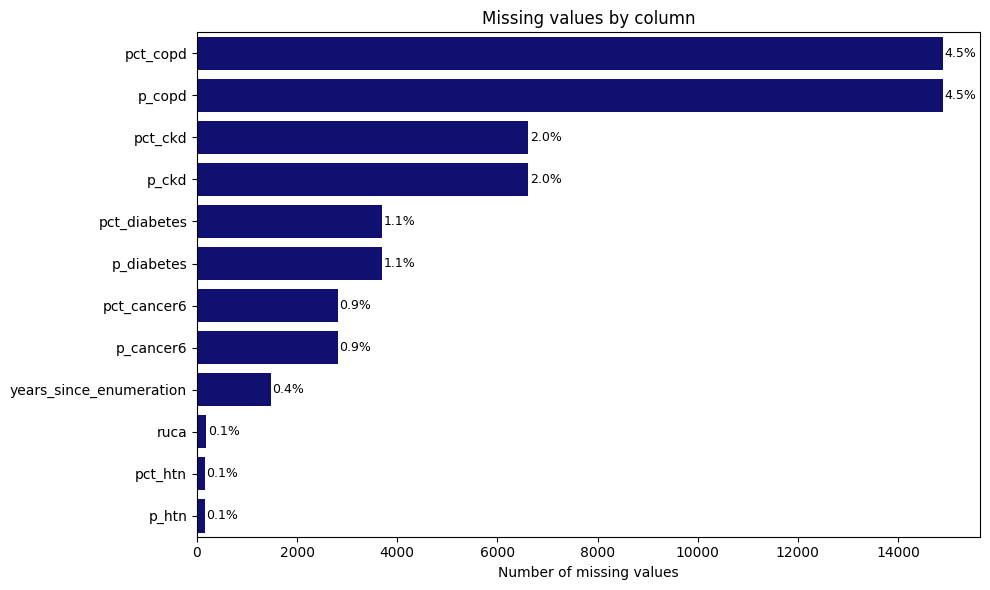

In [80]:
plt.figure(figsize=(10, max(4,0.5*len(miss))))

g = sns.barplot(data=miss, x="n_missing", y="column", orient="h", color="#000080")

max_missing = miss["n_missing"].max()

g.set(
    title="Missing values by column",
    xlabel="Number of missing values",
    ylabel=""
)

# 3) Annotate % missing
for i, (cnt, pct) in enumerate(zip(miss["n_missing"], miss["pct_missing"])):
    # Offset text slightly to the right of the bar
    g.text(cnt + (max_missing * 0.002), i, f"{pct:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [81]:
eda_df[["provider_type","Place_Of_Srvc","ruca_bucket","rbcs_family_desc"]].nunique()

provider_type         5
Place_Of_Srvc         2
ruca_bucket           4
rbcs_family_desc    113
dtype: int64

In [82]:
eda_df["provider_type"].unique()

array(['Hematology-Oncology', 'Radiation Oncology', 'Medical Oncology',
       'Surgical Oncology', 'Gynecological Oncology'], dtype=object)

In [83]:
eda_df["Place_Of_Srvc"].unique()

array(['F', 'O'], dtype=object)

In [84]:
eda_df["ruca_bucket"].unique()

array(['Urban', 'Suburban', 'Rural', 'Unknown'], dtype=object)

In [85]:
eda_df["rbcs_family_desc"].unique()[0:20]

array(['Office E&M - Established', 'Conventional Radiation Treatment',
       'Intravenous Infusion, Hydration', 'Office E&M - New',
       'Erythropoiesis - Stimulating Agent',
       'Injection - Growth/Hormone Factor',
       'Injection - Colony Stimulating Factors',
       'Injection - Somatostatin', 'Hospital E&M - Initial',
       'Hospital E&M - Subsequent',
       'Chronic and Transitional Care Management',
       'Vaccine Admin - Flu, Pneum, and Hep B',
       'Intensity Modulated Radiation Therapy',
       'COVID-19 Vaccine Administration', 'No RBCS Family',
       'Radiation Treatment Planning', 'Chemotherapeutic Agent',
       'Venipuncture Blood Collection', 'Vaccine - Toxoids',
       'Injection Administration'], dtype=object)

#### Important realization: `“No RBCS Family”` showing up in `rbcs_family_desc` is not automatically wrong, but it is worth verifying what it corresponds to. It might be a real label in the RBCS file, or it might indicate some mapping fallback.

### Quick check: If it’s truly mapped, RBCS_FamNumb should still be present and consistent.

In [86]:
con.sql(
    """
SELECT
  rbcs_family_desc,
  COUNT(*) AS n,
  MIN(RBCS_FamNumb) AS min_fam,
  MAX(RBCS_FamNumb) AS max_fam
FROM provider_service_features
WHERE rbcs_family_desc = 'No RBCS Family'
GROUP BY 1;
"""
)

┌──────────────────┬───────┬─────────┬─────────┐
│ rbcs_family_desc │   n   │ min_fam │ max_fam │
│     varchar      │ int64 │ varchar │ varchar │
├──────────────────┼───────┼─────────┼─────────┤
│ No RBCS Family   │ 25993 │ 000     │ 000     │
└──────────────────┴───────┴─────────┴─────────┘

#### `"No RBCS Family"` looks like a real, intentional value in your RBCS mapping, not a join failure.

#### Because:

#### - We have **RBCS_FamNumb = ‘000’** for every one of those rows (min and max both `000`), and the description is consistently `"No RBCS Family"`.
#### - If this were a join miss, we would typically see `RBCS_FamNumb` as `NULL` (or missing) after the join, not a stable sentinel like `000`.
#### - We also previously saw `pct_missing_rbcs = 0.0`, which strongly suggests the taxonomy file contains entries for these HCPCS codes and is assigning them to a “none/other/unclassified” bucket.

#### So it is probably a legitimate “catch-all” category: “this HCPCS code is in the taxonomy file but not assigned to a meaningful family.” But we have to confirm this finding.

#### Quick checks: How big is it relative to the dataset?

In [87]:
con.sql(
    """
SELECT
  COUNT(*) AS n_all,
  SUM(CASE WHEN RBCS_FamNumb='000' THEN 1 ELSE 0 END) AS n_000,
  1.0 * SUM(CASE WHEN RBCS_FamNumb='000' THEN 1 ELSE 0 END) / COUNT(*) AS pct_000
FROM provider_service_features;
"""
)

┌────────┬────────┬─────────────────────┐
│ n_all  │ n_000  │       pct_000       │
│ int64  │ int128 │       double        │
├────────┼────────┼─────────────────────┤
│ 329571 │  25993 │ 0.07886919662227562 │
└────────┴────────┴─────────────────────┘

#### Quick checks: Does it have very different cost/exposure?

In [88]:
con.sql(
    """
SELECT
  CASE WHEN RBCS_FamNumb='000' THEN '000_NoFamily' ELSE 'OtherFamilies' END AS grp,
  COUNT(*) AS n_rows,
  AVG(services) AS avg_services,
  quantile_cont(log_stdzd_amt_per_service, 0.50) AS med_log_stdzd,
  quantile_cont(log_stdzd_amt_per_service, 0.95) AS p95_log_stdzd
FROM eda_df
GROUP BY 1;
"""
)

┌───────────────┬────────┬───────────────────┬────────────────────┬───────────────────┐
│      grp      │ n_rows │   avg_services    │   med_log_stdzd    │   p95_log_stdzd   │
│    varchar    │ int64  │      double       │       double       │      double       │
├───────────────┼────────┼───────────────────┼────────────────────┼───────────────────┤
│ 000_NoFamily  │  25993 │ 12234.04850536683 │ 3.3826939100975957 │ 6.142579116825249 │
│ OtherFamilies │ 303578 │  2835.73869351534 │  4.291046929442693 │ 5.784211048322115 │
└───────────────┴────────┴───────────────────┴────────────────────┴───────────────────┘

#### This is exactly the kind of check that makes the story credible. Based on your results, I would treat RBCS_FamNumb = #### '000' as a real, meaningful segment and handle it explicitly.

####  **What these numbers are saying**

#### **Size**

#### - 000 is **7.9%** of rows (25,993 out of 329,571). That’s too big to ignore as a “quirk”, but small enough that it #### could distort things if it behaves differently.

#### **Exposure (services)**

#### - 000_NoFamily has **much higher average services** per row: ~12,234 vs ~2,836.
#### - That is a big structural difference. It suggests 000 rows are not “typical families”, they might be umbrella #### billing codes, very high volume codes, or catch-all codes that aggregate a lot of activity.

#### **Cost level (log standardized cost per service)**

#### - Median log cost is **lower** for 000 (3.38) vs others (4.29).
####     - On the original scale, that’s roughly exp(3.38) ≈ 29 vs exp(4.29) ≈ 73 (this is approximate because you used log1p, but the conclusion holds).
#### - The **95th percentile is similar-ish** (6.14 vs 5.78). So the tail is not wildly different, but the center is.

#### So yes, I would call it meaningfully different. Even if the p95 is close, the median and the services volume difference are telling you this group is a different “kind” of row.





<br>

#### **Quick extra check before locking the decision**

#### The one thing I’d verify is whether 000 is concentrated in a specific place of service or provider type.

In [89]:
con.sql(
    """
SELECT
  Place_Of_Srvc,
  provider_type,
  COUNT(*) AS n_rows,
  AVG(services) AS avg_services,
  quantile_cont(log_stdzd_amt_per_service, 0.50) AS med_log_stdzd
FROM eda_df
WHERE RBCS_FamNumb = '000'
GROUP BY 1,2
ORDER BY n_rows DESC;
"""
)

┌───────────────┬────────────────────────┬────────┬────────────────────┬───────────────────┐
│ Place_Of_Srvc │     provider_type      │ n_rows │    avg_services    │   med_log_stdzd   │
│    varchar    │        varchar         │ int64  │       double       │      double       │
├───────────────┼────────────────────────┼────────┼────────────────────┼───────────────────┤
│ O             │ Hematology-Oncology    │  10741 │  22764.76187505819 │  1.15926928806898 │
│ O             │ Medical Oncology       │   3508 │  18156.78720068415 │  1.20481350113386 │
│ F             │ Hematology-Oncology    │   2455 │  78.64684317718941 │ 4.097672352314776 │
│ F             │ Radiation Oncology     │   2230 │  75.68161434977578 │ 4.085348198572007 │
│ O             │ Radiation Oncology     │   2070 │  2657.969082125604 │ 4.001586659483845 │
│ F             │ Surgical Oncology      │   1583 │  44.85975994946305 │ 4.715727176552735 │
│ F             │ Gynecological Oncology │   1427 │  38.54660126138753

#### This table makes it very clear that **RBCS_FamNumb = '000'** is not just a harmless “misc” label. It behaves like multiple different sub-populations depending on place of service and provider type.

#### **What these result implies**

#### **1) The biggest driver is Place_Of_Srvc = O for HemOnc and MedOnc**

#### Look at these two rows:

#### - **O, Hematology-Oncology:** 10,741 rows, **avg_services ~ 22,765**, **median log cost ~ 1.16**
#### - **O, Medical Oncology:** 3,508 rows, **avg_services ~ 18,157**, **median log cost ~ 1.20**

#### That median log cost is extremely low relative to the rest of your dataset. These look like very high-volume, very low standardized cost-per-service rows, which is exactly the kind of pattern you get from “special” codes, aggregation-type codes, or something that is not comparable to a standard service family.

#### **2) The F rows look much more “normal”**

#### When Place_Of_Srvc = F, the median log costs are around ~4 to 6, and avg_services are tens, not tens of thousands. Example:

#### - **F, HemOnc:** avg_services ~ 79, med log ~ 4.10
#### - **F, RadOnc:** avg_services ~ 76, med log ~ 4.09
#### - **F, GynOnc:** avg_services ~ 39, med log ~ 6.24 (higher)

#### So 000 is not one thing. It’s at least two very different things depending on place of service.

#### **What to do with 000 now**

#### Two possible strategies:

#### **Option A (recommended): Keep 000, but model it explicitly with interactions**

#### Do all of this:

#### 1. Add a flag
#### - is_no_rbcs_family = 1 if RBCS_FamNumb == '000' else 0
#### 2. Add an interaction-type feature (either explicit or via model)
#### - For Ridge: you can explicitly create a feature like is_no_rbcs_family * is_place_O (or just rely on one-hot plus linear interaction if you build it).
#### - For XGBoost: you don’t need to manually create interactions. It will split on RBCS_FamNumb == '000' and Place_Of_Srvc naturally.
#### 3. In EDA and reporting, always show metrics stratified by:
#### - is_no_rbcs_family and Place_Of_Srvc

#### This gives you the clean story: “000 codes behave differently, especially in outpatient settings. We keep them but let the model treat them differently.”

#### **Option B (cleanest benchmarking narrative): Separate-track modeling**

#### - **Main benchmark model:** train on RBCS_FamNumb != '000' only.
#### - **Secondary model:** train on RBCS_FamNumb == '000' only (and maybe even split by Place_Of_Srvc inside it).

#### This avoids mixing apples and oranges. It also prevents those huge-volume low-cost O rows from influencing the main model’s learned relationships.

#### **Which option fits your goal best?**

#### Since we want the headline metric to be **O/E standardized cost per service** and we want the benchmarking story to be clean, here’s the best alignment:

#### - If the report/dashboard is meant to be “benchmark real oncology service families,” then **Option B** is the cleanest.
#### - If the product goal is “give every provider-year-service row an expected cost,” then **Option A** is better.



<br>

#### **One more tiny QC that will make the decision obvious**

#### Let's check whether those crazy high avg_services rows also dominate total volume. If (O, HemOnc) and (O, MedOnc) are most of the services too, then separating 000 is usually the safest.

In [90]:
con.sql(
    """
SELECT
  Place_Of_Srvc,
  provider_type,
  SUM(services) AS total_services,
  COUNT(*) AS n_rows,
  1.0 * SUM(services) / (SELECT SUM(services) FROM eda_df WHERE RBCS_FamNumb='000') AS pct_of_000_services
FROM eda_df
WHERE RBCS_FamNumb='000'
GROUP BY 1,2
ORDER BY total_services DESC;
"""
)

┌───────────────┬────────────────────────┬────────────────────┬────────┬────────────────────────┐
│ Place_Of_Srvc │     provider_type      │   total_services   │ n_rows │  pct_of_000_services   │
│    varchar    │        varchar         │       double       │ int64  │         double         │
├───────────────┼────────────────────────┼────────────────────┼────────┼────────────────────────┤
│ O             │ Hematology-Oncology    │ 244516307.29999998 │  10741 │     0.7689201174109064 │
│ O             │ Medical Oncology       │         63694009.5 │   3508 │    0.20029586494213913 │
│ O             │ Radiation Oncology     │          5501996.0 │   2070 │   0.017301894736712873 │
│ O             │ Gynecological Oncology │          3629235.0 │    677 │   0.011412702216576337 │
│ F             │ Hematology-Oncology    │           193078.0 │   2455 │  0.0006071642422086545 │
│ F             │ Radiation Oncology     │           168770.0 │   2230 │  0.0005307238999655819 │
│ F             │ Me

#### This confirms it very strongly.

#### **What this table says in plain English**

#### For the “No RBCS Family” bucket (RBCS_FamNumb = '000'):

#### - **Outpatient HemOnc (O, Hematology-Oncology)** accounts for **~76.9%** of *all* services in the 000 bucket.
#### - **Outpatient MedOnc (O, Medical Oncology)** accounts for **~20.0%**.
#### - Together, those two rows account for **~97%** of all 000 services.

#### Everything else is tiny by comparison.

#### So **RBCS_FamNumb='000'** is not just 7.9% of rows. It is a bucket whose *service volume* is overwhelmingly dominated by a very specific pattern (Outpatient + HemOnc/MedOnc). That means if you keep 000 in the main model without special handling, it can easily distort training, calibration, and the O/E story.

#### **Best recommendation**

#### Use **Option B (separate-track modeling)** as the default.

#### **Why Option B is the cleanest for your stated goal**

narrative usually assumes “we’re comparing like-with-like service families.” The 000 bucket is not behaving like a normal service family. It’s acting like a special aggregation or fallback code bucket with huge volume and very different cost behavior.

#### So:

#### 1. **Main benchmark model (the one you show by default)**
#### - Train and score on **RBCS_FamNumb != '000'** only.
#### - This becomes your primary O/E story.
#### 2. **Secondary model (optional add-on)**
#### - Train a separate model for **RBCS_FamNumb = '000'*, and honestly this could be restricted to just:
####    - (Place_Of_Srvc='O' AND provider_type IN ('Hematology-Oncology','Medical Oncology'))
####    - because that’s basically the whole 000 volume anyway.
#### - Or we can still include all provider types, but the key is keeping it separate from the main benchmark.

### **What to do in the dataset**

#### Keep 000 rows in your data, but tag them and split the pipeline:

#### - model_track = 'main' if RBCS_FamNumb != '000'
#### - model_track = 'no_family' if RBCS_FamNumb = '000'

#### Then you build:

#### - model_dataset_main.parquet
#### - model_dataset_no_family.parquet (optional, can come later)



<br>

#### **One more quick QC that’s worth doing**

#### Check whether 000 is also concentrated in **specific HCPCS codes** (often a sign it’s a special code pattern):

#### If we see a small number of HCPCS codes dominating, that further supports “special bucket” behavior.

In [91]:
con.sql(
    """
SELECT
  p.HCPCS_Cd,
  MAX(p.HCPCS_Desc) AS hcpcs_desc,
  COUNT(*) AS n_rows,
  SUM(p.Tot_Srvcs) AS total_services
FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl p
WHERE p.RBCS_FamNumb = '000'
GROUP BY 1
ORDER BY total_services DESC
LIMIT 20;
"""
)

┌──────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────┬────────────────┐
│ HCPCS_Cd │                                                                                                                            hcpcs_desc                                                                                                                            │ n_rows │ total_services │
│ varchar  │                                                                                                                             varchar                                                                                                                              │ int64  │     double     │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────

#### It seems like most of the descriptions are injections. We should confirm this by running a regex to show what percentage of all **RBCS_FamNumb = '000'** are described as "injections" at any context of specific drug.

#### Fast check: “Injection” share by rows and by services

#### If pct_services_injection is very high (for example > 0.7), then the “000 bucket” is essentially “drug units/injections” in your data.



<br>

#### Slightly broader keyword net

#### Some injection-related codes might not literally contain the word “injection” (for example contrast materials). We can create a broader “drug or injectable” bucket:

#### This will tell us whether “injection” alone explains most of the services, or if it’s “injection + contrast + unclassified drug” etc.

In [92]:
con.sql(
    """
WITH base AS (
  SELECT
    CASE
      WHEN lower(HCPCS_Desc) LIKE '%injection%' THEN 1
      ELSE 0
    END AS is_injection,
    Tot_Srvcs
  FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
  WHERE RBCS_FamNumb = '000'
)
SELECT
  COUNT(*) AS n_rows,
  SUM(is_injection) AS n_injection_rows,
  1.0 * SUM(is_injection) / COUNT(*) AS pct_rows_injection,

  SUM(Tot_Srvcs) AS total_services,
  SUM(CASE WHEN is_injection = 1 THEN Tot_Srvcs ELSE 0 END) AS injection_services,
  1.0 * SUM(CASE WHEN is_injection = 1 THEN Tot_Srvcs ELSE 0 END) / NULLIF(SUM(Tot_Srvcs), 0) AS pct_services_injection
FROM base;
"""
)

┌────────┬──────────────────┬────────────────────┬────────────────┬────────────────────┬────────────────────────┐
│ n_rows │ n_injection_rows │ pct_rows_injection │ total_services │ injection_services │ pct_services_injection │
│ int64  │      int128      │       double       │     double     │       double       │         double         │
├────────┼──────────────────┼────────────────────┼────────────────┼────────────────────┼────────────────────────┤
│ 144455 │            77115 │  0.533834065972102 │    317999622.8 │        290406955.0 │     0.9132305014797018 │
└────────┴──────────────────┴────────────────────┴────────────────┴────────────────────┴────────────────────────┘

#### Bonus: Let's use `HCPCS_Drug_Ind` in our `prov_svc_onco_core_prov_all_rbcs_nppes_tbl`

#### Our big table appears to have `HCPCS_Drug_Ind`. If it’s reliable, it’s cleaner than regex:

#### **What this means for our modeling decision**

#### If you confirm that 000 is mostly drug-unit injection codes:

#### - It strengthens the case to **exclude RBCS_FamNumb='000' from the main service-family benchmark model** (your Option B main track).
#### - Then you can treat 000 as a **secondary “drug units” track** later, with its own modeling logic and careful interpretation.

In [93]:
con.sql(
    """
WITH base AS (
  SELECT
    lower(HCPCS_Desc) AS d,
    Tot_Srvcs
  FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
  WHERE RBCS_FamNumb = '000'
),
tagged AS (
  SELECT
    CASE
      WHEN d LIKE '%injection%' THEN 'injection'
      WHEN d LIKE '%contrast%' THEN 'contrast'
      WHEN d LIKE '%unclassified drug%' OR d LIKE '%unclassified drugs%' THEN 'unclassified_drug'
      WHEN d LIKE '%chemotherap%' THEN 'chemo'
      WHEN d LIKE '%imaging%' OR d LIKE '%gadol%' OR d LIKE '%radiology%' THEN 'imaging_related'
      ELSE 'other'
    END AS bucket,
    Tot_Srvcs
  FROM base
)
SELECT
  bucket,
  COUNT(*) AS n_rows,
  SUM(Tot_Srvcs) AS total_services,
  1.0 * SUM(Tot_Srvcs) / (SELECT SUM(Tot_Srvcs) FROM tagged) AS pct_services
FROM tagged
GROUP BY 1
ORDER BY total_services DESC;
"""
)

┌───────────────────┬────────┬────────────────┬───────────────────────┐
│      bucket       │ n_rows │ total_services │     pct_services      │
│      varchar      │ int64  │     double     │        double         │
├───────────────────┼────────┼────────────────┼───────────────────────┤
│ injection         │  77115 │    290406955.0 │    0.9132305014797018 │
│ contrast          │   2841 │     21484037.0 │   0.06755994491701642 │
│ other             │  55557 │      5201991.5 │   0.01635848324031408 │
│ unclassified_drug │   4502 │       713898.3 │ 0.0022449658704437937 │
│ chemo             │   2553 │       149348.0 │ 0.0004696483558218862 │
│ imaging_related   │   1887 │        43393.0 │  0.000136456136702059 │
└───────────────────┴────────┴────────────────┴───────────────────────┘

In [94]:
con.sql(
    """
SELECT
  HCPCS_Drug_Ind,
  COUNT(*) AS n_rows,
  SUM(Tot_Srvcs) AS total_services,
  1.0 * SUM(Tot_Srvcs) / (SELECT SUM(Tot_Srvcs)
                          FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
                          WHERE RBCS_FamNumb='000') AS pct_services
FROM prov_svc_onco_core_prov_all_rbcs_nppes_tbl
WHERE RBCS_FamNumb='000'
GROUP BY 1
ORDER BY total_services DESC;
"""
)

┌────────────────┬────────┬────────────────┬─────────────────────┐
│ HCPCS_Drug_Ind │ n_rows │ total_services │    pct_services     │
│    varchar     │ int64  │     double     │       double        │
├────────────────┼────────┼────────────────┼─────────────────────┤
│ Y              │  88703 │    313115904.5 │  0.9846423770663667 │
│ N              │  55752 │      4883718.3 │ 0.01535762293363324 │
└────────────────┴────────┴────────────────┴─────────────────────┘

#### It seems that most of the RBCS_FamNumb='000'  are actually related to injections.

#### These three checks line up perfectly, and they give us a very defensible conclusion.
#### What your results mean
#### 1) “Injection” dominates by services (the important lens)
#### Only 53.4% of rows contain the word “injection”.
#### But those rows account for 91.3% of total services in the 000 bucket.
#### So the 000 bucket is not “half injections” in the sense that matters for modeling. It’s overwhelmingly injection volume.
#### 2) Your broader keyword tagging confirms the same story
#### Injection: 91.3% of services
#### Contrast: 6.8% of services
#### Everything else combined is small.
#### This is very consistent with “drug units and related items” rather than standard “service families.”
#### 3) The drug indicator seals it
#### HCPCS_Drug_Ind = 'Y' is 98.5% of services in 000.
#### That is huge. It means RBCS_FamNumb='000' is basically a drug-related bucket in your extracted oncology universe.
#### What we should do (clear recommendation)
#### Use the split-track approach:
#### Main benchmarking model (your portfolio headline)
#### Train and score ONLY on rows where:
#### RBCS_FamNumb IS NOT NULL
#### RBCS_FamNumb <> '000'
#### This is your clean “apples-to-apples service-family benchmarking engine.”
#### Secondary “drug unit” track (optional add-on)
#### Keep RBCS_FamNumb='000' rows separate.
#### If you include it later, frame it honestly as “drug unit and related codes (injections, contrast).”
#### It can be its own model or a descriptive module. It does not need to be part of the core benchmark story.
#### This aligns with your goal: make the primary narrative clean and interview-safe for Garner/Oscar.
#### How to describe this decision in your write-up
#### You can say something like:
#### “RBCS family ‘000’ represents non-standard family assignments in RBCS. In our oncology subset, it is overwhelmingly drug-related volume: 98.5% of services have HCPCS_Drug_Ind='Y', and 91.3% of services are codes whose description includes ‘injection’. Because drug unit billing behaves differently from service-family costs, we exclude RBCS ‘000’ from the main service-family benchmark model and treat it as a separate track.”
#### That sounds thoughtful, not like data cleaning hand-waving.

## Outcome distributions and log justification

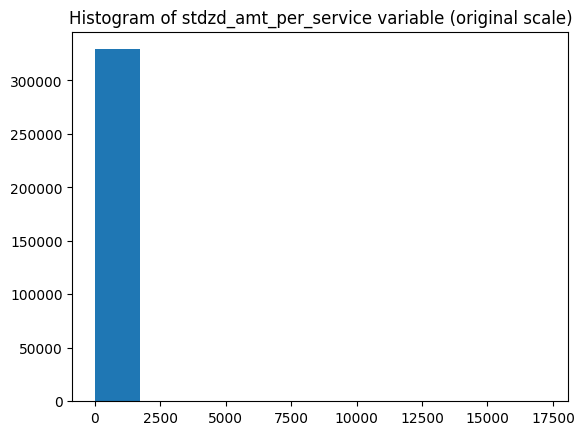

In [95]:
plt.hist(eda_df["stdzd_amt_per_service"])
plt.title("Histogram of stdzd_amt_per_service variable (original scale)")
plt.show()

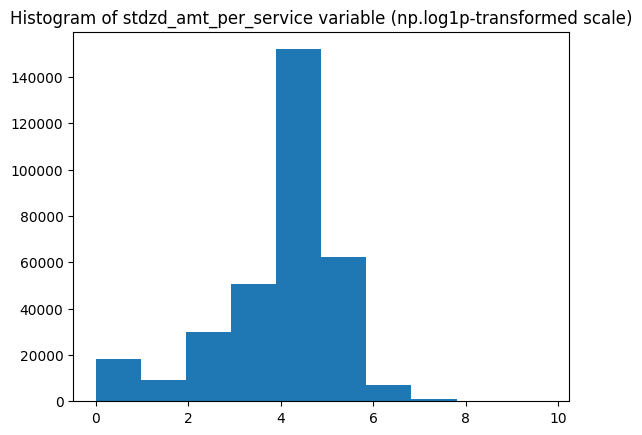

In [96]:
plt.hist(np.log1p(eda_df["stdzd_amt_per_service"]))
plt.title("Histogram of stdzd_amt_per_service variable (np.log1p-transformed scale)")
plt.show()

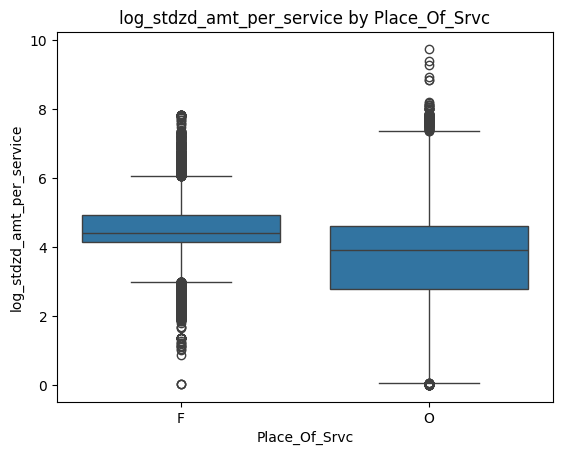

In [97]:
g = sns.boxplot(data=eda_df,
                x = "Place_Of_Srvc",
                y="log_stdzd_amt_per_service")
g.set_title("log_stdzd_amt_per_service by Place_Of_Srvc")
plt.show()

In [98]:
cols = ["stdzd_amt_per_service", "allowed_amt_per_service", "payment_amt_per_service"]

percentiles = eda_df[cols].quantile([0.01, 0.5, 0.9, 0.95, 0.99])

max_vals = eda_df[cols].max().to_frame().T
max_vals.index = [1.0]

result = pd.concat([percentiles, max_vals])
print(result)



      stdzd_amt_per_service  allowed_amt_per_service  payment_amt_per_service
0.01               0.118456                 0.150202                 0.117630
0.50              69.715955                93.082234                70.829815
0.90             157.020000               209.680000               163.903333
0.95             327.002895               400.830229               318.351347
0.99             592.728642               763.992314               609.241805
1.00           17228.780462             21978.744923             17580.387538


### Exposure, reliability, and threshold selection

#### Histogram of services: The distribution of exposure (how many services went into each row’s per-service cost).


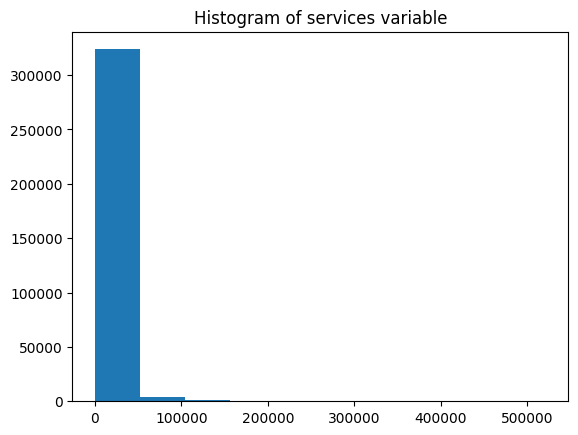

In [99]:
plt.hist(eda_df["services"])
plt.title("Histogram of services variable")
plt.show()

#### The histogram is xtremely right-skewed. Most rows have relatively low services, and a small number of rows have massive service counts (up to ~500k). That is normal in claims-like utilization data.

#### Low-service rows have noisier “per service” averages. High-service rows have very stable averages.

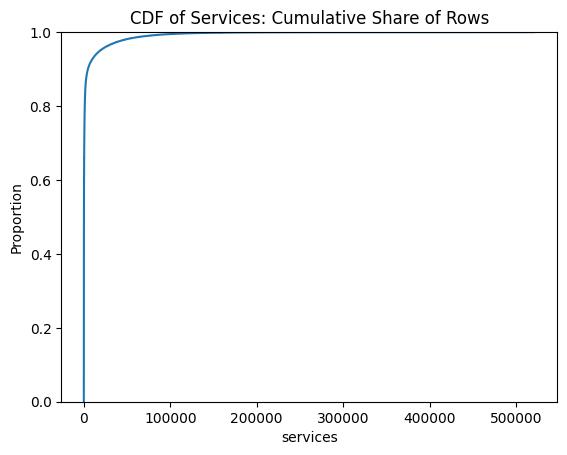

In [100]:
sns.ecdfplot(data = eda_df, x="services")
plt.title("CDF of Services: Cumulative Share of Rows")
plt.show()

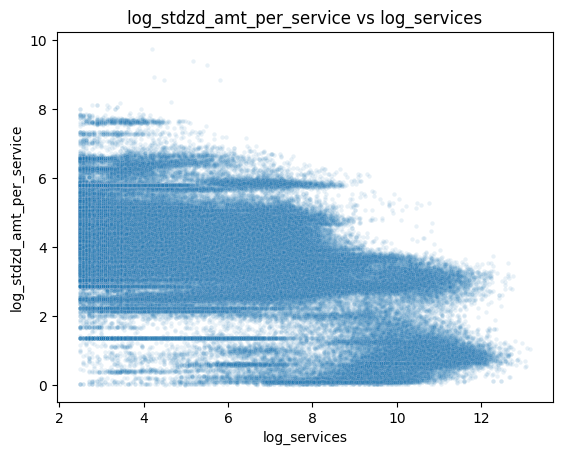

In [110]:
eda_df["log_services"] = np.log1p(eda_df["services"])

g = sns.scatterplot(data=eda_df, x = "log_services", y="log_stdzd_amt_per_service", alpha=0.1, s=10)
g.set_title("log_stdzd_amt_per_service vs log_services")
plt.show()

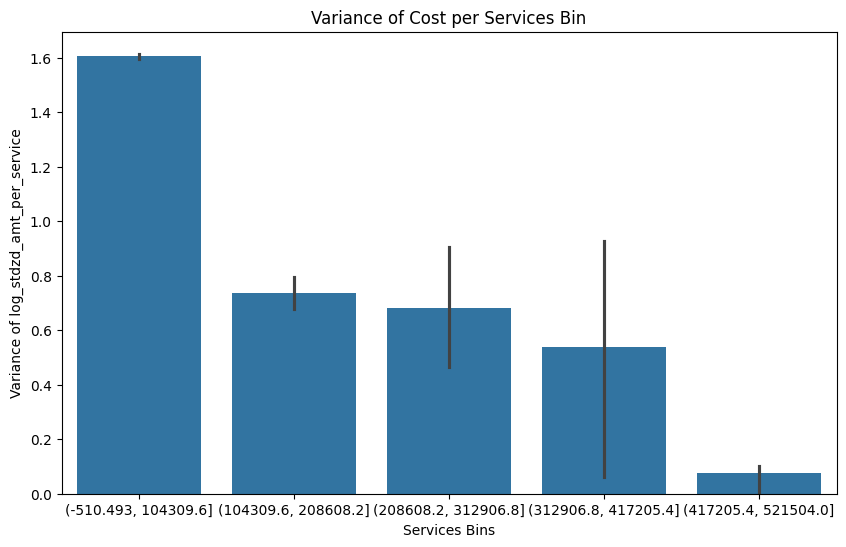

In [102]:
# 1. Create a binned version of 'services' (e.g., 5 equal-width bins)
eda_df['services_bins'] = pd.cut(eda_df['services'], bins=5)

# 2. Plot variance per bin
plt.figure(figsize=(10, 6))
sns.barplot(data=eda_df, x='services_bins', y='log_stdzd_amt_per_service', estimator=np.var)

plt.title('Variance of Cost per Services Bin')
plt.ylabel('Variance of log_stdzd_amt_per_service')
plt.xlabel('Services Bins')
plt.show()

In [111]:
# Define custom edges: 0 to 11, 11 to 25, 25 to 50, 50 to 100, and 100+
custom_bins = [0, 11, 25, 50, 100, np.inf]
custom_labels = ['0-11', '12-25', '26-50', '51-100', '100+']

# Create the binned column
eda_df['services_custom'] = pd.cut(
    eda_df['services'], 
    bins=custom_bins, 
    labels=custom_labels, 
    include_lowest=True
)

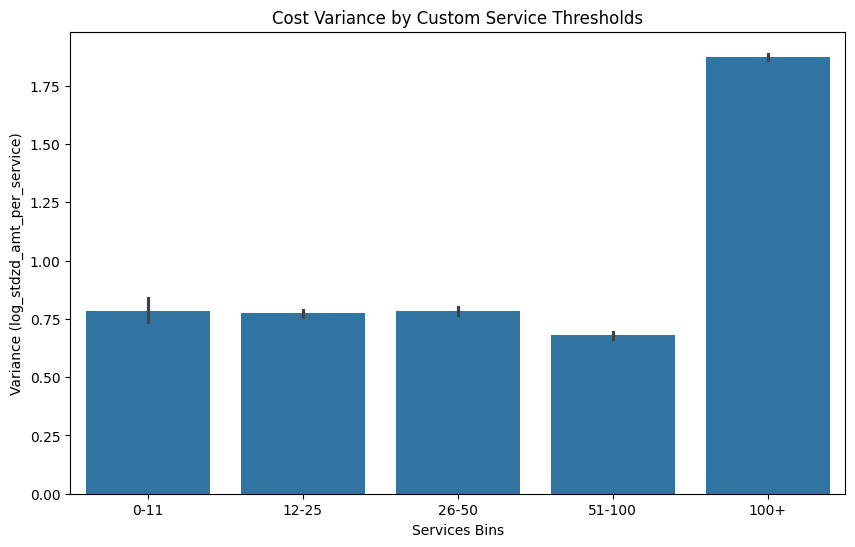

In [112]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=eda_df, 
    x='services_custom', 
    y='log_stdzd_amt_per_service', 
    estimator=np.var
)

plt.title('Cost Variance by Custom Service Thresholds')
plt.ylabel('Variance (log_stdzd_amt_per_service)')
plt.xlabel('Services Bins')
plt.show()


#### **Adding counts per bin**

#### We need to know if 100+ has a small number of rows (unstable estimate) or tons (real pattern).

In [113]:
eda_df.groupby("services_custom").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    var_y=("log_stdzd_amt_per_service", np.var),
    mean_y=("log_stdzd_amt_per_service","mean"),
    p95=("log_stdzd_amt_per_service", lambda s: np.quantile(s, 0.95))
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/2312683007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/2312683007.py:1: FutureWarning: The provided callable <function var at 0x10a01f380> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom").agg(


,n_rows,var_y,mean_y,p95
services_custom,,,,
0-11,4299,0.785006,4.651056,6.000313
12-25,48431,0.774682,4.570140,5.807632
26-50,48115,0.784619,4.577514,5.807632
51-100,46713,0.678864,4.472975,5.801616
100+,182013,1.874238,3.508058,5.042196


#### **Split 100+ into sub-bins**

#### Keep your early bins, but break 100+ into a few more. For example:

#### - 101–250
#### - 251–1,000
#### - 1,001–10,000
#### - 10,000+

#### If the variance spike is really coming from, say, the “10k+” group, that is an important story.

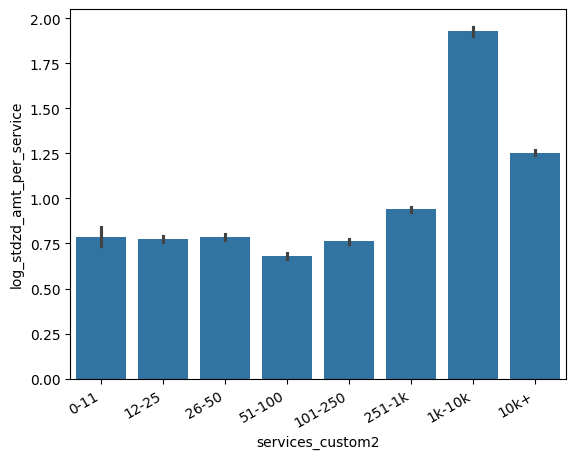

In [114]:
bins2 = [0, 11, 25, 50, 100, 250, 1000, 10000, np.inf]
labels2 = ["0-11","12-25","26-50","51-100","101-250","251-1k","1k-10k","10k+"]

eda_df["services_custom2"] = pd.cut(eda_df["services"], bins=bins2, labels=labels2, include_lowest=True)

sns.barplot(data=eda_df, x="services_custom2", y="log_stdzd_amt_per_service", estimator=np.var)
plt.xticks(rotation=30, ha="right")
plt.show()

#### **Let's also use IQR as a robustness check**

#### Variance can be misleading. IQR tells you the “middle spread.”

In [115]:
def iqr(s):
    return np.quantile(s, 0.75) - np.quantile(s, 0.25)

eda_df.groupby("services_custom").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    iqr_y=("log_stdzd_amt_per_service", iqr),
    var_y=("log_stdzd_amt_per_service", np.var)
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/3614687459.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/3614687459.py:4: FutureWarning: The provided callable <function var at 0x10a01f380> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom").agg(


,n_rows,iqr_y,var_y
services_custom,,,
0-11,4299,0.811965,0.785006
12-25,48431,0.858816,0.774682
26-50,48115,0.822936,0.784619
51-100,46713,0.780356,0.678864
100+,182013,1.570977,1.874238


In [116]:
eda_df.groupby("services_custom2").agg(
    n_rows=("log_stdzd_amt_per_service","size"),
    iqr_y=("log_stdzd_amt_per_service", lambda s: np.quantile(s,0.75)-np.quantile(s,0.25)),
    var_y=("log_stdzd_amt_per_service", np.var)
    
)

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/147435524.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom2").agg(
/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/147435524.py:1: FutureWarning: The provided callable <function var at 0x10a01f380> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  eda_df.groupby("services_custom2").agg(


,n_rows,iqr_y,var_y
services_custom2,,,
0-11,4299,0.811965,0.785006
12-25,48431,0.858816,0.774682
26-50,48115,0.822936,0.784619
51-100,46713,0.780356,0.678864
101-250,46849,0.665268,0.761057
251-1k,66114,0.984226,0.939108
1k-10k,45103,1.394142,1.926705
10k+,23947,2.157479,1.252477


In [117]:
tmp = (
    eda_df.groupby("services_custom2")
    .agg(
        n_rows=("services","size"),
        total_services=("services","sum")
    )
)
tmp["pct_rows"] = tmp["n_rows"] / tmp["n_rows"].sum()
tmp["pct_services"] = tmp["total_services"] / tmp["total_services"].sum()
tmp.sort_index()

/var/folders/yx/5t5dfjxj4pv8tjn2zvbfc2540000gn/T/ipykernel_79531/3134475691.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df.groupby("services_custom2")


,n_rows,total_services,pct_rows,pct_services
services_custom2,,,,
0-11,4299,47289.0,0.013044,0.000040
12-25,48431,855168.0,0.146952,0.000725
26-50,48115,1772484.0,0.145993,0.001504
51-100,46713,3353777.1,0.141739,0.002845
101-250,46849,7569534.1,0.142151,0.006421
251-1k,66114,35359955.6,0.200606,0.029995
1k-10k,45103,137631698.4,0.136854,0.116749
10k+,23947,992277597.7,0.072661,0.841721


#### **Service mix and spend concentration (core storytelling)**

#### **Plots**

#### 1. Top 15 families by total services:
####    - bar: SUM(services) by rbcs_family_desc
#### 2. Top 15 families by total standardized spend:
####    - bar: SUM(stdzd_spend) by family
#### 3. Pareto chart:
####    - cumulative percent of spend captured by top families

In [ ]:
sum_srvc_by_rbcs_family_desc = eda_df.groupby("rbcs_family_desc").agg(services_sum = ("services", "sum"))